In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

# import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [73]:
df = pd.read_csv('../data/model_data/salaries_with_stats.csv')
df.head(2)

,player,nhl_api_id_number,team,cap hit %,aav,length,weight,height,drafted,slide cand.,...,shifts,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,shotPct,shots,timeOnIce,position_F,shoots_Right,contract_is_two_way
0,Connor McDavid,8478402,EDM,16.7,12500000.0,8,193,185,1,0,...,3028.0,1.0,2.0,100.966667,27.2,356.0,2582.600000,1,0,0
1,Artemi Panarin,8478550,NYR,14.3,11642857.0,7,168,180,218,0,...,7328.0,0.0,0.0,8.766667,57.2,817.0,6277.516667,1,1,0


In [74]:
df = df.dropna(axis=0)

df = df[df['length'] <= 8]

df = df.drop([21, 670], axis=0)

df.index = [i for i in range(len(df.index))]

df.columns

Index(['player', 'nhl_api_id_number', 'team', 'cap hit %', 'aav', 'length',
       'weight', 'height', 'drafted', 'slide cand.', 'waivers exempt',
       'arb. elig', 'signing age', 'was_RFA_at_signing', 'is_RFA_at_expiry',
       'goals', 'assists', 'points', 'blocked', 'evenTimeOnIce', 'faceOffPct',
       'gameWinningGoals', 'games', 'hits', 'overTimeGoals', 'pim',
       'plusMinus', 'powerPlayGoals', 'powerPlayPoints', 'powerPlayTimeOnIce',
       'shifts', 'shortHandedGoals', 'shortHandedPoints',
       'shortHandedTimeOnIce', 'shotPct', 'shots', 'timeOnIce', 'position_F',
       'shoots_Right', 'contract_is_two_way'],
      dtype='object')

In [75]:
y = to_categorical(df['length'].values.reshape((len(df.index),-1)),
                   num_classes=9)

feature_cols = list(df.columns[6:])
X = df[feature_cols]

# standardize the features
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [76]:
df.length.unique()

array([8, 7, 5, 6, 4, 3, 2, 1])

In [77]:


def build_model():
    input_dim = len(feature_cols)
    
    model = Sequential()
    model.add(Dense(8, input_dim = input_dim , activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(9, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )
    return model

# build model
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 8)                 280       
_________________________________________________________________
dense_59 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_60 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_61 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_62 (Dense)             (None, 9)                 99        
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


In [78]:
epochs = 1000
history = model.fit(X_train, y_train,
                    epochs=epochs, 
                    validation_split = 0.2, 
                    verbose=0)

In [79]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.head(10)

,val_loss,val_acc,loss,acc,epoch
0,2.103390,0.317757,2.162640,0.252927,0
1,2.059073,0.317757,2.116445,0.257611,1
2,1.998031,0.317757,2.068844,0.257611,2
3,1.944568,0.317757,2.011911,0.257611,3
4,1.883064,0.317757,1.960015,0.257611,4
5,1.833954,0.317757,1.907438,0.257611,5
6,1.797697,0.308411,1.851205,0.257611,6
7,1.763972,0.299065,1.795254,0.269321,7
8,1.740148,0.289720,1.739522,0.264637,8
9,1.729635,0.308411,1.697060,0.288056,9


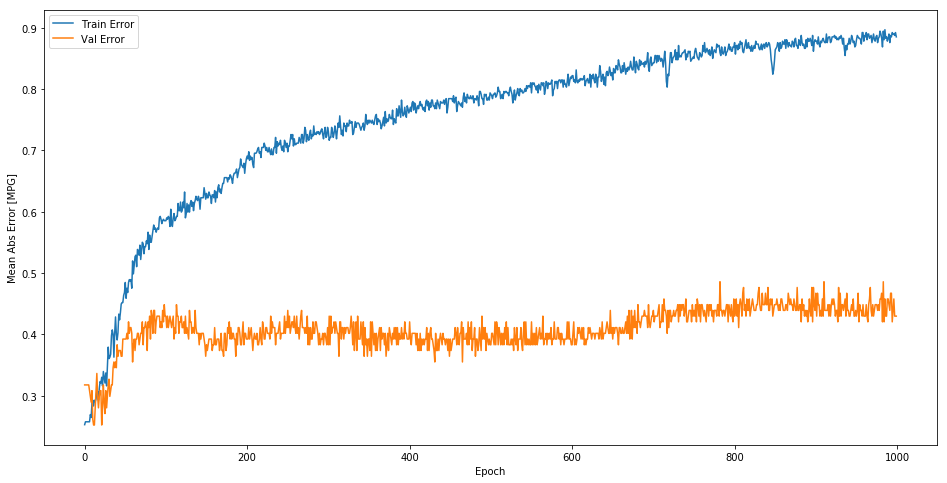

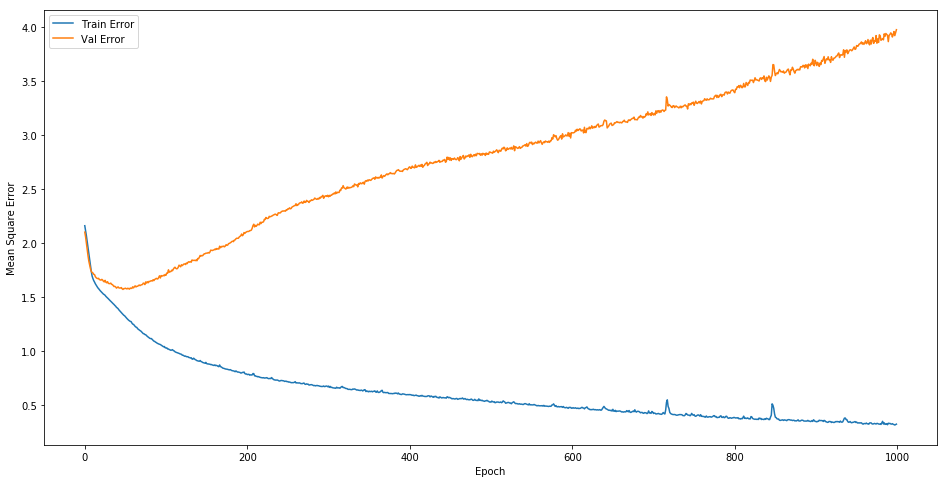

In [80]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['acc'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Error')
    plt.legend()

    plt.figure(figsize=(16,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()
    plt.show()


plot_history(history)

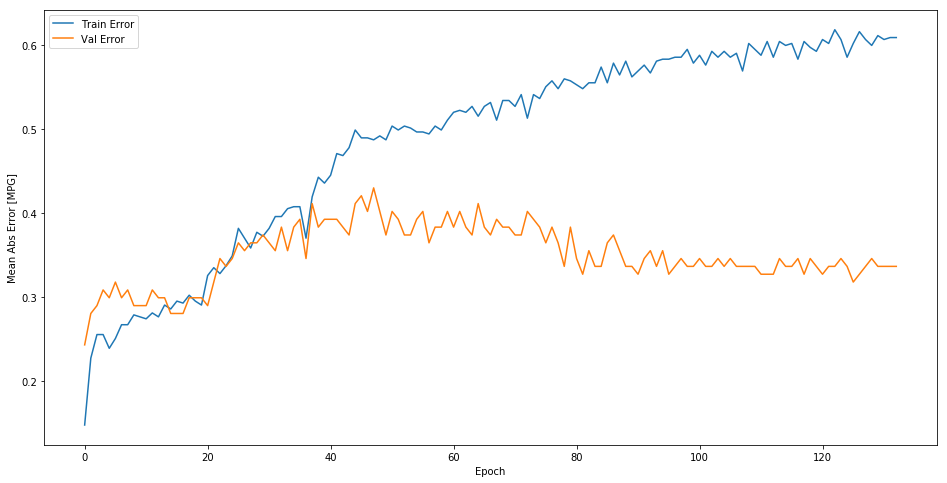

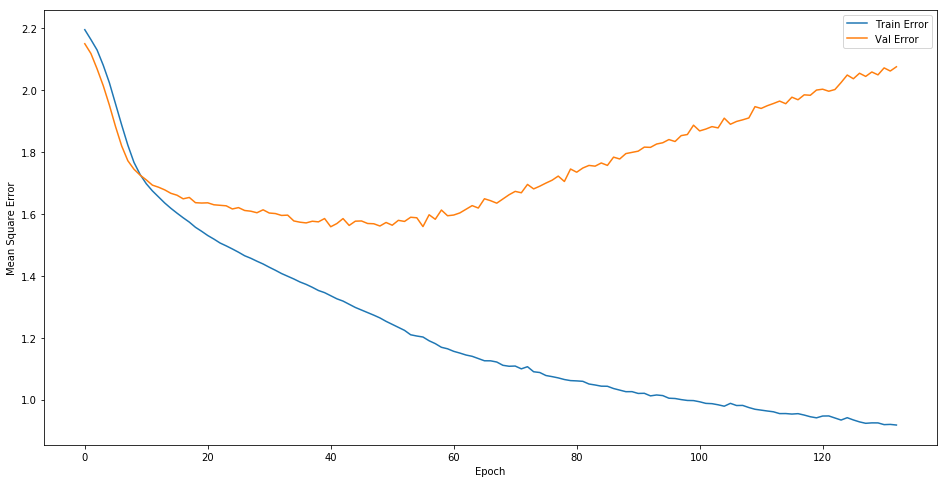

In [81]:
# instantiate new model
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='acc', patience=10)

epochs = 1000
history = model.fit(X_train, y_train,
                    epochs=epochs, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop])

plot_history(history)

In [82]:
# instantiate new model
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='acc', patience=10)

epochs = 1000
history = model.fit(X, y,
                    epochs=epochs, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[early_stop])

In [83]:
preds = model.predict(X)

In [84]:
for i in range(9):
    if i ==0:
        df[f'prob_length_None'] = preds[:, i]
    else:
        df[f'prob_length_{i}'] = preds[:, i]

In [86]:
df.columns

Index(['player', 'nhl_api_id_number', 'team', 'cap hit %', 'aav', 'length',
       'weight', 'height', 'drafted', 'slide cand.', 'waivers exempt',
       'arb. elig', 'signing age', 'was_RFA_at_signing', 'is_RFA_at_expiry',
       'goals', 'assists', 'points', 'blocked', 'evenTimeOnIce', 'faceOffPct',
       'gameWinningGoals', 'games', 'hits', 'overTimeGoals', 'pim',
       'plusMinus', 'powerPlayGoals', 'powerPlayPoints', 'powerPlayTimeOnIce',
       'shifts', 'shortHandedGoals', 'shortHandedPoints',
       'shortHandedTimeOnIce', 'shotPct', 'shots', 'timeOnIce', 'position_F',
       'shoots_Right', 'contract_is_two_way', 'prob_length_None',
       'prob_length_1', 'prob_length_2', 'prob_length_3', 'prob_length_4',
       'prob_length_5', 'prob_length_6', 'prob_length_7', 'prob_length_8'],
      dtype='object')

In [92]:
pd.options.display.float_format = '{:,.4f}'.format

probs = df[['player', 'length', 'prob_length_None', 'prob_length_1', 'prob_length_2', 'prob_length_3', 'prob_length_4',
    'prob_length_5', 'prob_length_6', 'prob_length_7', 'prob_length_8' ]]

In [96]:
probs.sort_values('prob_length_8', ascending=False).head(10)

,player,length,prob_length_None,prob_length_1,prob_length_2,prob_length_3,prob_length_4,prob_length_5,prob_length_6,prob_length_7,prob_length_8
606,Brian Pinho,1,0.0000,0.0009,0.0013,0.0000,0.0002,0.0031,0.0101,0.0242,0.9601
13,Evgeni Malkin,8,0.0000,0.0067,0.0073,0.0005,0.0041,0.0515,0.0721,0.0841,0.7736
18,Steven Stamkos,8,0.0000,0.0005,0.0005,0.0008,0.0025,0.0202,0.0370,0.1686,0.7700
10,Tyler Seguin,8,0.0000,0.0044,0.0050,0.0011,0.0059,0.0556,0.0790,0.1234,0.7256
3,Erik Karlsson,8,0.0000,0.0164,0.0147,0.0003,0.0049,0.0891,0.0955,0.0636,0.7155
8,Anze Kopitar,8,0.0000,0.0551,0.0518,0.0001,0.0027,0.0734,0.0783,0.0246,0.7140
7,Patrick Kane,8,0.0000,0.0007,0.0007,0.0009,0.0039,0.0340,0.0545,0.1969,0.7084
20,Ryan Getzlaf,8,0.0000,0.0241,0.0173,0.0001,0.0039,0.1072,0.0978,0.0464,0.7031
5,Drew Doughty,8,0.0000,0.0080,0.0040,0.0000,0.0036,0.1365,0.1140,0.0731,0.6607
78,Tyler Myers,5,0.0000,0.0010,0.0008,0.0000,0.0022,0.0778,0.1208,0.1559,0.6415
